In [1]:
from gibbs.dataclass import GibbsResult,get_results
import numpy as np
from gibbs.utils import simple_purify_hamiltonian,printarray,spectral_dec
import matplotlib.pyplot as plt
from gibbs.learning.bayesian_learning import BayesianLearning
from gibbs.learning.constraint_matrix import ConstraintMatrixFactory
from gibbs.plots.plots import compare_preparations, axis_locality
import plotly.express as px
from qiskit.quantum_info import state_fidelity

%load_ext autoreload
%autoreload 2
gibbsresults = get_results("../scripts_lap/job_13_qasm")
res = gibbsresults[0]

In [2]:
cmat = ConstraintMatrixFactory(res.num_qubits,k_learning=3,k_constraints=4)
K,E = cmat.create_cmat(res.state_vector(-1),3e6)

In [3]:
s,v = spectral_dec(K)

(111,) (111,)
The reconstruction difers by 6.690e-02,and the spectral gap is 0.004018045316554063
The estimated error is prop to 29.078592664016377 if we want  a prcecision of 0.01 we will need 8.456e+06 nshots.


/home/drudis/python_environements/gibbsvenv/lib64/python3.10/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


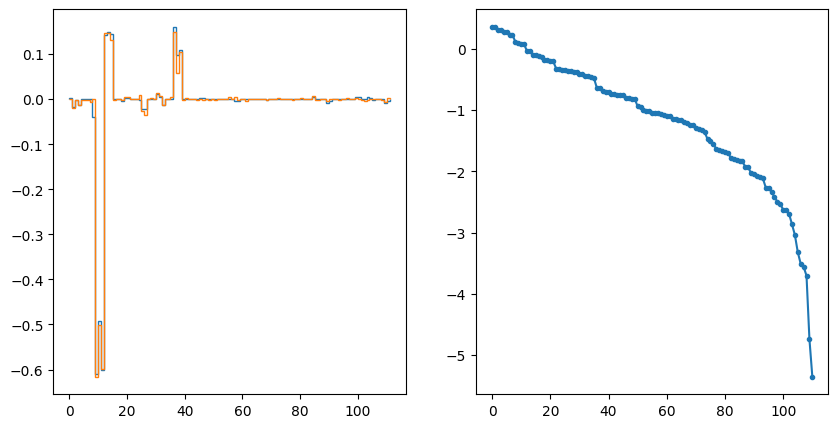

In [4]:
c_original_prior = res.cfaulties[-1]
candidate = v[-1][:c_original_prior.size].copy(); candidate *= np.linalg.norm(c_original_prior)
print(candidate.shape,c_original_prior.shape)
if np.linalg.norm(c_original_prior + candidate) < np.linalg.norm(c_original_prior - candidate):
    candidate = -candidate  
    
fig,ax = plt.subplots(1,2,figsize=(10,5))
ax[0].stairs(c_original_prior,lw=1)
ax[0].stairs(candidate)
# ax[0].stairs(res.cfaulties[-1])
ax[1].plot(np.log(s),marker=".")
sp_gap = s[-2]-s[-1]
print(f"The reconstruction difers by {np.linalg.norm(candidate-c_original_prior):.3e},and the spectral gap is {sp_gap}")
prec = 1e-2
error = np.sqrt(sum(1/(s[:-1]-s[-1])))
nshots = (error/prec)**2
print(f"The estimated error is prop to {error} if we want  a prcecision of {prec} we will need {nshots:.3e} nshots.")

In [5]:
def error(shots):
    K,E = cmat.create_cmat(res.state_vector(-1),shots)
    s,v = spectral_dec(K)
    c_original_prior = res.cfaulties[-1]
    candidate = v[-1][:c_original_prior.size].copy(); candidate *= np.linalg.norm(c_original_prior)
    if np.linalg.norm(c_original_prior + candidate) < np.linalg.norm(c_original_prior - candidate):
        candidate = -candidate
    err = np.linalg.norm(candidate-c_original_prior)
    return err
xshots = np.logspace(4,8,num=100,base=10)
errors = [error(s) for s in xshots]

In [6]:
fig = px.scatter(x=xshots,y=errors,log_x=True,log_y=True)
# fig.add_scatter(x=xshots,y=1e2*xshots**(-0.5))
fig.show()